In [1]:
from models.det_allhist_glm2 import Det_AllHist_GLM

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

#####
V[V < 0.3] = 0

In [3]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 750
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 20000
epoch_no = iter_no*batch_size//T_train 
layer_no = 3

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

###
part_V_train = V_train[:50000].to(device)
part_train_E_neural = train_E_neural[:50000].to(device)
part_train_I_neural = train_I_neural[:50000].to(device)
###


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Det_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

132


In [6]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, Z_pred, P_pred, out_filters = model(batch_E_neural, batch_I_neural)
        
    #loss = torch.mean((V_pred - batch_V)**2)
    loss = torch.var(V_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred, test_Z_pred, test_P_pred, test_out_filters = model(test_E_neural, test_I_neural) 
        train_V_pred, train_Z_pred, train_P_pred, train_out_filters = model(part_train_E_neural, part_train_I_neural) 
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_var = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        train_mse = torch.mean((train_V_pred - part_V_train)**2).item()
        train_var = explained_variance_score(part_V_train.cpu().detach().numpy(), train_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_var, 6),
              np.round(test_mse, 6),
              np.round(train_var, 6),
              np.round(train_mse, 6)
              #torch.sum(test_Z_pred).item(),
             #model.W_out.item(),
             #model.Tau_out.item()
             )


<ipython-input-6-d3963eb5c55a>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -0.63905 94.765717 -0.475302 94.732155
199 -0.435432 68.82695 -0.323823 68.799423
299 -0.312846 52.169823 -0.232632 52.14682
399 -0.237662 41.399902 -0.176706 41.380211
499 -0.189606 34.220589 -0.140963 34.20335
599 -0.15477 28.818165 -0.115053 28.802954
699 -0.128118 24.54142 -0.095231 24.527954
799 -0.10745 21.12492 -0.079861 21.112959
899 -0.091351 18.387072 -0.067888 18.376408
999 -0.079518 16.3239 -0.05909 16.314278
1099 -0.069869 14.606105 -0.051915 14.597403
1199 -0.061757 13.132725 -0.045883 13.124855
1299 -0.054714 11.828397 -0.040647 11.821304
1399 -0.048475 10.650908 -0.036009 10.644555
1499 -0.043272 9.651925 -0.032141 9.646233
1599 -0.038695 8.75881 -0.028738 8.753736
1699 -0.034805 7.98761 -0.025847 7.983096
1799 -0.031478 7.318111 -0.023373 7.314108
1899 -0.028501 6.710933 -0.021161 6.707413
1999 -0.025851 6.163089 -0.019192 6.160023
2099 -7.962833 5.422328 -4.544559 5.471389
2199 -0.021564 5.258834 -0.016005 5.256566
2299 -0.019809 4.881838 -0.014702 4.879923
2399 -0

KeyboardInterrupt: 

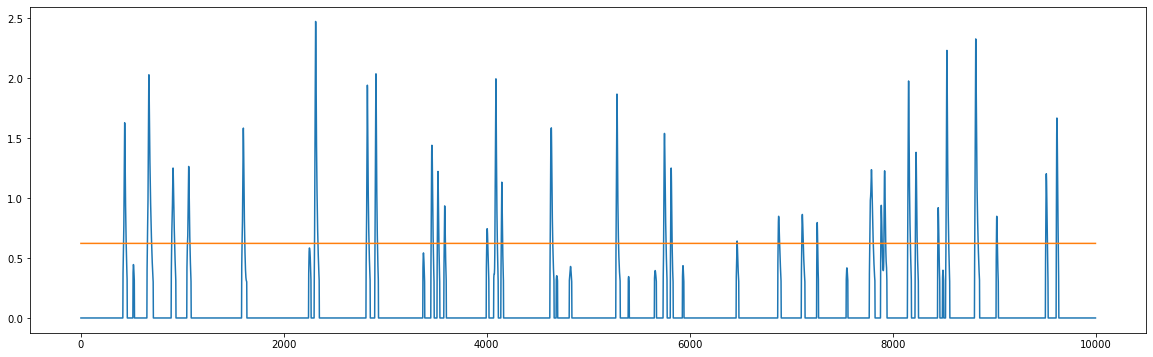

In [7]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])


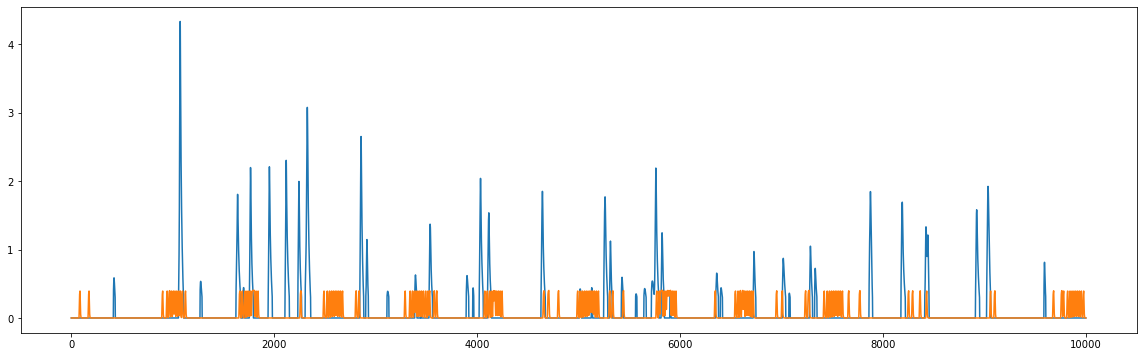

In [8]:
plt.figure(figsize=(20,6))
plt.plot(part_V_train.cpu().detach().numpy()[16000:26000])
plt.plot(train_V_pred.cpu().detach().numpy()[16000:26000])
